In [1]:
import pandas as pd
import numpy as np
import copy
import random
from math import sqrt
import scipy.stats as sts

from tqdm.notebook import tqdm

from supplement_package import game
from supplement_package import variables_pecan

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [3]:
from supplement_package.game.stackelberg import StackelbergPlayer

In [4]:
import gurobipy as gp

from supplement_package.gurobi_implementation.gurobi import GurobiSolution

In [5]:
agent_keys = [661, 1642, 2335, 2361, 2818, 3039, 3456, 3538, 4031, 4373, 4767, 5746, 6139, 7536, 7719, 7800, 7901, 7951, 8156, 8386, 8565, 9019, 9160, 9922, 9278]

dataframe_dict = dict()
for key in agent_keys:
    dataframe_dict.update({key : pd.read_csv('/Users/ishilov/Documents/risk_paper/risk_paper/data/df_{}.csv'.format(key))})

community_size = len(dataframe_dict)

for key in agent_keys:
    cond_min = (dataframe_dict[key]['demand'].quantile(0.001) <= dataframe_dict[key]['demand'])
    cond_max = (dataframe_dict[key]['demand'] <= dataframe_dict[key]['demand'].quantile(0.999))
    dataframe_dict[key] = dataframe_dict[key][cond_min & cond_max]

In [6]:
def generate_new_params(sample_size, community_size):
    res = {}

    for sample in range(sample_size):
        A_tilde = [random.uniform(0,1) for i in range(community_size)]
        B_tilde = [random.uniform(0,1) for i in range(community_size)]

        a = [random.uniform(0,1) for i in range(community_size)]
        b = [random.uniform(0,1) for i in range(community_size)]
        d = [random.uniform(0,1) for i in range(community_size)]

        #d_target = [[random.uniform(0,8) for j in range(len(probabilities))] for i in range(community_size)]
        #g_res = [[random.uniform(0,3) for j in range(len(probabilities))] for i in range(community_size)]

        #g_res = np.array(g_res)
        #d_target = np.array(d_target)

        risk_aversion = [random.uniform(0,1) for i in range(community_size)]

        res.update({sample : {'A_tilde' : A_tilde,
                        'B_tilde' : B_tilde,
                        'a' : a,
                        'b' : b,
                        'd' : d,
                        'risk_aversion' : risk_aversion}})

    res_reformed = {(i, key) : res[i][key] for i in range(sample_size) for key in res[0].keys()}
    mindx = pd.MultiIndex.from_tuples(res_reformed.keys())
    df = pd.DataFrame(list(res_reformed.values()), index = mindx)
    df.to_csv(f'../data/param_{sample_size}_beta.csv')

In [7]:
def read_df_param(sample_size):
    df_param = pd.read_csv(f'../data/param_{sample_size}.csv')
    df_param.rename({'Unnamed: 0' : 'Sample', 'Unnamed: 1' : 'Parameter'}, axis=1, inplace= True)
    df_param.set_index(['Sample', 'Parameter'], inplace=True)

    return df_param

In [8]:
param_amount = 2000

df_param = read_df_param(param_amount)

In [9]:
def param_input(df, index = 0):
    A_tilde = list(df.loc[index].loc['A_tilde'])
    B_tilde = list(df.loc[index].loc['B_tilde'])
    a = list(df.loc[index].loc['a'])
    b = list(df.loc[index].loc['b'])
    d = list(df.loc[index].loc['d'])
    risk_aversion = list(df.loc[index].loc['risk_aversion'])

    for i, RA in enumerate(risk_aversion):
        if RA > 0.95:
            risk_aversion[i] = risk_aversion[i] - 0.1

    return A_tilde, B_tilde, a, b, d, risk_aversion

In [10]:
def sample_from_csv(scenario_amount):
    df_d_target = pd.read_csv(f'../data/df_d_target_{scenario_amount}.csv').drop('Unnamed: 0', axis = 1)
    df_g_res = pd.read_csv(f'../data/df_g_res_{scenario_amount}.csv').drop('Unnamed: 0', axis = 1)
    df_probabilities =pd.read_csv('../data/df_probabilities_100.csv').drop('Unnamed: 0', axis = 1)
    
    probabilities = df_probabilities.values.squeeze()


    d_target = []
    for _, row in df_d_target.iterrows():
        d_target.append(row.values)

    g_res = []
    for _, row in df_g_res.iterrows():
        g_res.append(row.values)

    return probabilities, d_target, g_res
    

In [11]:
probabilities, d_target, g_res = sample_from_csv(100)

In [12]:
D_min = [0 for i in range(community_size)]
D_max = [dataframe_dict[i].demand.max() for i in dataframe_dict.keys()]

G_min = [0 for i in range(community_size)]
G_max = [dataframe_dict[i].grid.max() for i in dataframe_dict.keys()]

Kappa = [[10 if i!=j else 0 for i in range(community_size)] for j in range(community_size)]

Cost = [[1 for i in range(community_size)] for j in range(community_size)]

In [13]:
def agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, false_risk_aversion, probabilities, connection_matrix, d_target, g_res):
    agents = []
    StackelbergPlayer.community_size = community_size
    StackelbergPlayer.probabilities = probabilities

    epsilon = 0.0000001
    alpha = [[proba/(1 - min(false_risk_aversion)) - epsilon for proba in probabilities] for i in range(community_size)]
    #alpha = [[0.2 for proba in probabilities] for i in range(community_size)]
    gamma = [proba/(1 - min(risk_aversion)) for proba in probabilities]

    j_max = [10 for i in range(community_size)]

    for i in range(community_size):
        agent = StackelbergPlayer(i, d_target[i], g_res[i], a[i], b[i], d[i], 
                    A_tilde[i], B_tilde[i], D_min[i], D_max[i], 
                    G_min[i], G_max[i], risk_aversion[i], Kappa[i], Cost[i], connection_matrix[i],
                    probabilities = probabilities,
                    alpha = alpha[i], 
                    gamma = gamma, 
                    insurance_bound=j_max[i])
        
        agents.append(agent)

    return agents

In [14]:
false_RA_list = [[np.random.beta(1, 1) for i in range(community_size)] for j in range(500)]

In [15]:
def vars_to_dict(model, list_vars):
    var_names = []
    
    for var in model.getVars():
        var_names.append(var.VarName)

    dict_res = {}
    for name, var in zip(var_names, list_vars):
        dict_res.update({name : var})

    return dict_res 


In [16]:
def gurobi_experiment(df_param, index, err_track, connection_matrix, false_RA, probabilities, d_target, g_res, solution_type, verbosity = 0):

    A_tilde, B_tilde, a, b, d, risk_aversion = param_input(df_param, index = index)

    if solution_type == 'centralized_optimistic' or solution_type == 'centralized_pessimistic':
        agents = agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, false_RA, probabilities, connection_matrix, d_target, g_res)

    

    model_1 = gp.Model()
    setup = GurobiSolution(agents=agents,
                    model = model_1,
                    solution_type=solution_type)

    model_1.setParam('OutputFlag', verbosity)

    setup.build_model()

    try:
        model_1.optimize()

        list_vars = model_1.X
        dict_vars = vars_to_dict(model_1, list_vars)
        objective_val = model_1.getObjective().getValue()
        
        
        
    except:
        err_track.append(index)
        list_vars = ['err']
        objective_val = 'err'
        dict_vars = vars_to_dict(model_1, list_vars)

    return dict_vars, objective_val, model_1

In [17]:
def text_to_adj_matrix(matrix_path):
    res = []
    with open(matrix_path) as file:
        for s in file:
            string = ''.join(s.strip().strip(',').split(', '))
            lst_temp = [int(sym) for sym in string]

            res.append(lst_temp)

    return res

In [18]:
connection_matrix_2 = text_to_adj_matrix('../matrices/matrix_2.txt')

In [19]:
def experiment(probabilities, connection_matrix, false_RA_list, d_target, g_res,
                df_param, solution_type='centralized_optimistic', verbosity = 0):

    total_results= {}
    err_track = []
    for index, false_RA in tqdm(enumerate(false_RA_list)):
        vars, objective, model = gurobi_experiment(df_param, 0, err_track, connection_matrix, false_RA, probabilities, d_target, g_res, solution_type, verbosity)
        total_results.update({index: {'vars' : vars,
                                    'objective' : objective}})


    results_vars = pd.DataFrame(data = [list(total_results[0]['vars'].values())],
                                        columns=total_results[0]['vars'].keys())

    results_vars['objective'] = total_results[0]['objective']

    for i in tqdm(range(1, len(total_results))):
        df_temp = pd.DataFrame(data = [list(total_results[i]['vars'].values())],
                                            columns=total_results[i]['vars'].keys())
                                
        df_temp['objective'] = total_results[i]['objective']

        results_vars = pd.concat([results_vars, df_temp], ignore_index=True)

    return total_results, results_vars, model

In [20]:
res_opt, df_opt, model_opt = experiment(probabilities, connection_matrix_2, false_RA_list, d_target, g_res,
            df_param, solution_type='centralized_pessimistic')

0it [00:00, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

In [21]:
def agent_utility_from_df_row(df_row, agents):
    res = []
    for agent in agents:
        eta_idx = f'eta_{agent.id}'
        agent_obj = df_row[eta_idx]

        for proba in agent.probabilities_ind:
            u_idx = f'u_{agent.id}_{proba}'
            w_idx = f'W_{agent.id}_{proba}'
            j_idx = f'J_{agent.id}_{proba}'

            agent_obj += (agent.alpha[proba] * df_row[j_idx]
                        + agent.gamma[proba] * df_row[w_idx]
                        + agent.probabilities[proba] / (1 - agent.risk_aversion) * df_row[u_idx])

        res.append(agent_obj)

    return res
    

In [22]:
def IC_utility_from_df_row(df_row, agents):
    res = 0

    for agent in agents:
        for proba in agent.probabilities_ind:
            j_idx = f'J_{agent.id}_{proba}'

            res += - agent.alpha[proba] * df_row[j_idx] + agent.probabilities[proba] * df_row[j_idx]

    return res

In [23]:
agent_objectives = []
A_tilde, B_tilde, a, b, d, risk_aversion = param_input(df_param, 0)
for index, row in df_opt.iterrows():
    agents = agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, false_RA_list[index], probabilities, connection_matrix_2, d_target, g_res)
    agent_objectives.append(agent_utility_from_df_row(row, agents))

In [24]:
IC_objective = []
A_tilde, B_tilde, a, b, d, risk_aversion = param_input(df_param, 0)

for index, row in df_opt.iterrows():
    agents = agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, false_RA_list[index], probabilities, connection_matrix_2, d_target, g_res)
    IC_objective.append(IC_utility_from_df_row(row, agents))

In [25]:
IC_objective = pd.Series(IC_objective, name='IC objective incomplete beta')

In [26]:
IC_objective.to_csv('../data/IC_objective_incomlete_beta_1_1.csv')

In [27]:
IC_1 = pd.read_csv('../data/IC_objective_incomlete_beta_2_2.csv')
IC_1.drop(['Unnamed: 0'], axis = 1, inplace = True)
IC_2 = pd.read_csv('../data/IC_objective_incomlete_beta_05_1.csv')
IC_2.drop(['Unnamed: 0'], axis = 1, inplace = True)
IC_3 = pd.read_csv('../data/IC_objective_incomlete_beta_1_05.csv')
IC_3.drop(['Unnamed: 0'], axis = 1, inplace = True)
IC_4 = pd.read_csv('../data/IC_objective_incomlete_beta_1_1.csv')
IC_4.drop(['Unnamed: 0'], axis = 1, inplace = True)

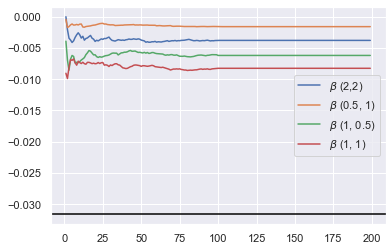

In [46]:
plt.plot([IC_1[:5*i].mean() for i in range(200)], label = r'$\beta$ (2,2)')
plt.plot([IC_2[:5*i].mean() for i in range(200)], label = r'$\beta$ (0.5, 1)')
plt.plot([IC_3[:5*i].mean() for i in range(200)], label = r'$\beta$ (1, 0.5)')
plt.plot([IC_4[:5*i].mean() for i in range(200)], label = r'$\beta$ (1, 1)')
plt.axhline(y = -0.031639, color = 'black')
plt.legend();

In [50]:
[IC_4[:5*i].mean() for i in range(200)]

[IC objective incomplete beta   NaN
 dtype: float64,
 IC objective incomplete beta   -0.009049
 dtype: float64,
 IC objective incomplete beta   -0.009889
 dtype: float64,
 IC objective incomplete beta   -0.008083
 dtype: float64,
 IC objective incomplete beta   -0.006869
 dtype: float64,
 IC objective incomplete beta   -0.006974
 dtype: float64,
 IC objective incomplete beta   -0.006759
 dtype: float64,
 IC objective incomplete beta   -0.007363
 dtype: float64,
 IC objective incomplete beta   -0.007751
 dtype: float64,
 IC objective incomplete beta   -0.007115
 dtype: float64,
 IC objective incomplete beta   -0.007342
 dtype: float64,
 IC objective incomplete beta   -0.007489
 dtype: float64,
 IC objective incomplete beta   -0.007286
 dtype: float64,
 IC objective incomplete beta   -0.007511
 dtype: float64,
 IC objective incomplete beta   -0.007599
 dtype: float64,
 IC objective incomplete beta   -0.007298
 dtype: float64,
 IC objective incomplete beta   -0.0073
 dtype: float64,
 IC o

In [30]:
false_RA_list

[[0.7115181893539555,
  0.7946454595406997,
  0.7536467153955761,
  0.4272343628957148,
  0.565194192686998,
  0.2714334140754611,
  0.9889578310058577,
  0.9005185319701048,
  0.6246877209790733,
  0.2699285491951679,
  0.1320781811164575,
  0.8069263826656332,
  0.5899480705405638,
  0.10055907417157806,
  0.5691263448319029,
  0.8200592063001455,
  0.4486823042515209,
  0.7930782780499595,
  0.3692901676960783,
  0.5194505364876038,
  0.7470654255597351,
  0.1521365997037283,
  0.7009653611529435,
  0.5603669742131542,
  0.011815720873586576],
 [0.15761910775839197,
  0.5941102268212204,
  0.024384095736486144,
  0.7667069743989136,
  0.02751551540163274,
  0.05971551017084558,
  0.2021161629057702,
  0.5744347503524819,
  0.3969723134554647,
  0.7283693741498771,
  0.1998500023775918,
  0.8609024063334273,
  0.5142618512421386,
  0.3051790783595916,
  0.1379002551806821,
  0.3581878398626218,
  0.573521821688194,
  0.10261562557183336,
  0.2660588813233213,
  0.29129592145245187,
 